In [87]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import cohen_kappa_score

# Import classes for clustering and dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import libraries for Hypertuning
import optuna
from optuna.samplers import TPESampler

# Import libraries for gradient boosting
import lightgbm as lgb
import xgboost as xgb

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
logistic = pd.read_csv("/kaggle/input/logisticplayground/sample_submission13 (1) (1).csv")

In [88]:
class WineDataProcessor:
    
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df

    def add_columns(self, df):
        df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
        df['acid/density'] = df['total_acid']  / df['density']
        df['alcohol_density'] = df['alcohol']  * df['density']
        df['sulphate/density'] = df['sulphates']  / df['density']
        df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
        df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
        df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
        return df
    
    def process_data(self):
        self.train_df = self.add_columns(self.train_df).assign(
            pH_round1 = self.train_df['pH'].round(1),
            log1p_residual_sugar = np.log1p(self.train_df['residual sugar']),
            citric_acid_per_alcohol = np.where(self.train_df['alcohol'] == 0, 0, self.train_df['citric acid'] / self.train_df['alcohol']),
        ).assign(
            citric_acid_type = lambda df: df['citric acid'].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)),
            alcohol_mean_groupby_pH = lambda df: df.groupby('pH_round1')['alcohol'].transform('mean')
        )

        self.test_df = self.add_columns(self.test_df).assign(
            pH_round1 = self.test_df['pH'].round(1),
            log1p_residual_sugar = np.log1p(self.test_df['residual sugar']),
            citric_acid_per_alcohol = np.where(self.test_df['alcohol'] == 0, 0, self.test_df['citric acid'] / self.test_df['alcohol']),
        ).assign(
            citric_acid_type = lambda df: df['citric acid'].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)),
            alcohol_mean_groupby_pH = lambda df: df.groupby('pH_round1')['alcohol'].transform('mean')
        )

        return self.train_df, self.test_df
        
      

In [89]:
class OptunaRounder:
    
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = np.unique(y_true)
        
    def __call__(self, trial):
        thresholds = []
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
            
        except: return 0
        
        return cohen_kappa_score(self.y_true, opt_y_pred, weights = 'quadratic')
    
    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred, 
                           [-np.inf] + thresholds + [np.inf], 
                           labels = self.labels)
        return opt_y_pred
        

In [90]:
def read_csv(path):
    
    return pd.read_csv(path)

def train_lgbm_model(X_train, y_train, y_val, lgb_params_best):
    
    lgbm_model = lgb.LGBMClassifier(**lgb_params_best)
    lgbm_model.fit(X_train, y_train, eval_set = (X_val, y_val), early_rounds = 200, verbose = 500)
    lgbm_pred_val = lgbm_model.predict(X_val)
    lgbm_score = cohen_kappa_score(y_val, lgbm_pred_val, weights = 'quadratic')
    return lgbm_pred_val, lgbm_score, lgbm_model

def train_xgboost_model(X_train, y_train, X_val, y_val, xgb_params_best):
    
    xgb_model = lgb.LGBMClassifier(**xgb_params_best)
    xgb_model.fit(X_train, y_train, eval_set = (X_val, y_val), early_rounds = 200, verbose = 500)
    xgb_pred_val = lgbm_model.predict(X_val)
    xgb_score = cohen_kappa_score(y_val, xgb_pred_val, weights = 'quadratic')
    return xgb_pred_val, xgb_score, xgb_model

def predict_with_threshold(model, test_df, score, threshold):
    
    if score > threshold:
        test_preds = model.predict(test_df)
        return test_preds, score 
    
    return None

In [91]:
# Paths to train and test datasets
TRAIN_PATH = "/kaggle/input/playground-series-s3e5/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s3e5/test.csv"
ADDITIONAL_PATH = "/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv"

# Load datasets into dataframes
train_df = read_csv(TRAIN_PATH)
test_df  = read_csv(TEST_PATH)
additional = read_csv(ADDITIONAL_PATH)

# Concatenate the additional data to the train_df and reset index
train_df = pd.concat([train_df,additional]).reset_index(drop=True)

# Drop the 'Id' column from both train_df and test_df
train_df = train_df.drop(columns=['Id'])
test_df = test_df.drop(columns=['Id'])

# Initialize the WineDataProcessor and process the data
processor = WineDataProcessor(train_df, test_df)
train_df, test_df = processor.process_data()

# Define the features and target for modeling
features = ['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']
target = 'quality'

# Change the quality column to 0, 1, 2, 3, 4, 5
train_df['quality'] = train_df['quality'] - 3

k-means

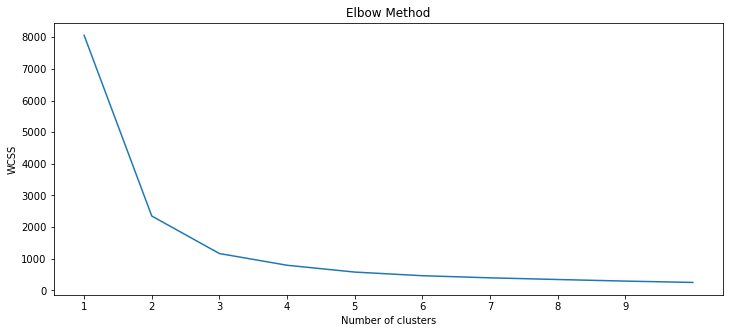

In [92]:
def find_best_n_clusters(data, max_clusters = 10):
    
    wcss = []
    
    for n in range(1, max_clusters+1):
        
        kmeans = KMeans(n_clusters = n, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        
        wcss.append(kmeans.inertia_)
        
    x = [1,2,3,4,5,6,7,8,9]
    
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(range(1, max_clusters+1), wcss)
    # Set the x axis labels to integers
    ax.xaxis.set_ticks(x)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

find_best_n_clusters(train_df[features].values)

pca

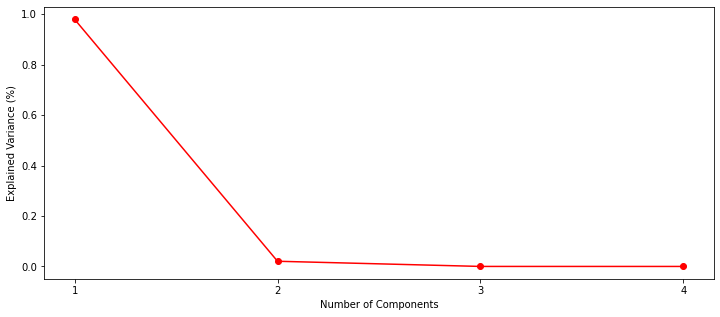

1

In [93]:
def find_optimal_num_components(X):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    num_components = np.arange(len(explained_variance)) + 1
    # Plot the elbow graph
    x = [1, 2, 3, 4]
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(num_components, explained_variance, 'ro-')
    ax.xaxis.set_ticks(x)
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance (%)")
    plt.show()
    
    optimal_num_components = None
    for i in range(len(explained_variance) - 1):
        if explained_variance[i] >= 0.95 * explained_variance[i + 1]:
            optimal_num_components = i + 1
            break
    return optimal_num_components

find_optimal_num_components(train_df[features].values)

In [94]:
def create_new_features(train_df, test_df, features):
    
    # Standardise the features for KMeans
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])

    # Perform KMeans clustering on the training data
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(X_train)

    # Reduce the dimensions of the training data using PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    train_df["cluster"] = kmeans.labels_
    train_df["pca_1"] = X_train_pca[:, 0]
    train_df["pca_2"] = X_train_pca[:, 1]

    # Standardise the features for KMeans
    X_test = scaler.transform(test_df[features])

    # Reduce the dimensions of the test data using PCA
    X_test_pca = pca.transform(X_test)
    test_df["cluster"] = kmeans.predict(X_test)
    test_df["pca_1"] = X_test_pca[:, 0]
    test_df["pca_2"] = X_test_pca[:, 1]
    
    return train_df, test_df


train_df, test_df = create_new_features(train_df, test_df, features)
#this is what I wanted 
features = [i for i in train_df.columns if i != 'quality']

In [95]:
def objective(trial):
    
    minority_class = [0, 5, 1]
    num_classes = len(train_df[target].unique())
    scale_pos_weight = [0] * num_classes
    for count, value in enumerate(train_df[target].unique()):
        num_neg_samples = len(train_df[train_df[target] != value])
        num_pos_samples = len(train_df[train_df[target] == value])
        scale_pos_weight[count] = num_neg_samples / num_pos_samples if num_pos_samples > 0 else 1
    scale_pos_weight = float(np.mean(scale_pos_weight))

    lgb_params_optuna = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 1.0),
        'objective': 'multiclass',
        'random_state': 42,
        'scale_pos_weight': scale_pos_weight
    }

    n_cv = trial.suggest_int('n_cv', 3, 10)
    cv = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=42)
    fold_scores = []
    for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
        X_train, y_train = train_df.loc[train_idx, features], train_df.loc[train_idx, target]
        X_val, y_val = train_df.loc[val_idx, features], train_df.loc[val_idx, target]

        _, lgbm_score, lgbm_model = train_lgbm_model(X_train, y_train, X_val, y_val, lgb_params_optuna)

        fold_scores.append(lgbm_score)

    return np.mean(fold_scores)

# study = optuna.create_study(direction='maximize', sampler = TPESampler())
# study.optimize(objective, n_trials=100)

# print("Best trial:")
# trial = study.best_trial

# print("Value: ", trial.value)
# print("Params: ")
# for key, value in trial.params.items():
#     print(f'{key}: {value}')
    
lgb_params_best = {
    "boosting_type": "goss",
    "num_leaves": 60,
    "learning_rate": 0.21054071748114178,
    "n_estimators": 479,
    "max_depth": 7,
    "min_child_samples": 193,
    "subsample": 0.5669437422243876,
    "colsample_bytree": 0.47626537911344274,
    "reg_alpha": 0.9998325542320676,
    "reg_lambda": 0.7675133032375039,
}


In [96]:
def objective(trial):
    
    num_classes = len(train_df[target].unique())
    
    xgb_params = {
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'objective': 'multi:softmax',
        'num_class': num_classes,
        "tree_method":"hist",
        'random_state': 42
    }

    n_cv = trial.suggest_int('n_cv', 3, 10)
    cv = StratifiedKFold(n_cv, shuffle=True, random_state=42)
    fold_scores = []
    for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
        X_train, y_train = train_df.loc[train_idx, features], train_df.loc[train_idx, target]
        X_val, y_val = train_df.loc[val_idx, features], train_df.loc[val_idx, target]

        _, xgb_score, xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val, xgb_params)
        fold_scores.append(xgb_score)
        
    return np.mean(fold_scores)

# study = optuna.create_study(direction='maximize', sampler = TPESampler())
# study.optimize(objective, n_trials=100)

# print("Best trial:")
# trial = study.best_trial

# print("Value: ", trial.value)
# print("Params: ")
# for key, value in trial.params.items():
#     print(f'{key}: {value}')
    
xgb_params_best={
        "max_depth": 3,
        "learning_rate": 0.2908331559320798,
        "n_estimators": 573
    }

In [97]:
k = 10
cv = StratifiedKFold(k, shuffle=True, random_state=42)

# Initialise empty lists to store the results of each fold
fold_scores = []
test_preds = []
oof_preds = []
oof_true = []

# Loop over the training and validation indices for each fold
for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
    
    # Split the training and validation sets
    X_train = train_df.loc[train_idx, features]
    y_train = train_df.loc[train_idx, target]
    X_val = train_df.loc[val_idx, features]
    y_val = train_df.loc[val_idx, target]
    
    # Fit and make predictions with XGBoost model
    XGB_MODEL = xgb.XGBClassifier(**xgb_params_best)
    XGB_MODEL.fit(X_train, y_train, eval_set= [(X_val,y_val)], early_stopping_rounds = 200, verbose=200)
    XGB_pred = XGB_MODEL.predict(X_val)
    XGB_SCORE = cohen_kappa_score(y_val,XGB_pred,weights='quadratic')
    
    # Only consider the predictions from the models that perform well
    if XGB_SCORE > 0.36:
        test_preds.append(XGB_MODEL.predict(test_df[features]) * 0.7 + 0.3 * np.array(logistic.quality - 3))
        fold_scores.append(XGB_SCORE)
    
    # Fit and make predictions with LightGBM model
    LGB_MODEL = lgb.LGBMClassifier(**lgb_params_best)
    LGB_MODEL.fit(X_train, y_train, eval_set= [(X_val,y_val)], early_stopping_rounds = 200, verbose=200)
    LGB_pred = LGB_MODEL.predict(X_val)
    LGB_SCORE = cohen_kappa_score(y_val,LGB_pred,weights='quadratic')
    
    # Only consider the predictions from the models that perform well
    if LGB_SCORE > 0.36:
        test_preds.append(LGB_MODEL.predict(test_df[features]) * 0.7 + 0.3 * np.array(logistic.quality - 3))
        fold_scores.append(LGB_SCORE)
    
    # Append the mean predictions for each fold to the oof_preds list
    oof_preds.extend(0.4 * XGB_pred + 0.6 * LGB_pred)
    oof_true.extend(y_val)

[0]	validation_0-mlogloss:1.53382
[200]	validation_0-mlogloss:1.08957
[238]	validation_0-mlogloss:1.11836
[200]	valid_0's multi_logloss: 1.06351
[0]	validation_0-mlogloss:1.51969
[200]	validation_0-mlogloss:1.00938
[263]	validation_0-mlogloss:1.03734
[200]	valid_0's multi_logloss: 1.05541
[0]	validation_0-mlogloss:1.51856
[200]	validation_0-mlogloss:0.99499
[247]	validation_0-mlogloss:1.02152
[200]	valid_0's multi_logloss: 1.0191
[0]	validation_0-mlogloss:1.52885
[200]	validation_0-mlogloss:1.16046
[220]	validation_0-mlogloss:1.17402
[200]	valid_0's multi_logloss: 1.19913
[0]	validation_0-mlogloss:1.51394
[200]	validation_0-mlogloss:0.96663
[248]	validation_0-mlogloss:0.98419
[200]	valid_0's multi_logloss: 1.03882
[0]	validation_0-mlogloss:1.52575
[200]	validation_0-mlogloss:1.05664
[222]	validation_0-mlogloss:1.06238
[200]	valid_0's multi_logloss: 1.08031
[0]	validation_0-mlogloss:1.50992
[200]	validation_0-mlogloss:0.96861
[262]	validation_0-mlogloss:1.00156
[200]	valid_0's multi_log

In [98]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
objective = OptunaRounder(oof_true, oof_preds)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, timeout=100)

/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:194: RuntimeWarning: invalid value encountered in subtract
  return np.log(np.exp(weighted_log_pdf - max_[:, np.newaxis]).sum(axis=1)) + max_
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:194: RuntimeWarning: invalid value encountered in subtract
  return np.log(np.exp(weighted_log_pdf - max_[:, np.newaxis]).sum(axis=1)) + max_
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:194: RuntimeWarning: invalid value encountered in subtract
  return np.log(np.exp(weighted_log_pdf - max_[:, np.newaxis]).sum(axis=1)) + max_
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:194: RuntimeWarning: invalid value encountered in subtract
  return np.log(np.exp(weighted_log_pdf - max_[:, np.newaxis]).sum(axis=1)) + max_
/opt/conda/lib/python3.7/site-packages/optuna/samplers/_tpe/parzen_estimator.py:194: RuntimeWarning: invalid val

In [99]:
# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
print(f'Optimized thresholds: {best_thresholds}')

oof_pred_opt = objective.adjust(oof_preds, best_thresholds)
best_score = cohen_kappa_score(oof_true, oof_pred_opt, weights='quadratic')
print(f'Optimized OOF Score: {best_score:.5f}')

Optimized thresholds: [0.6195520961518973, 1.78131686098238, 2.2728463902282208, 3.184077357865756, 3.625176151635183]
Optimized OOF Score: 0.52600


In [100]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')
test_preds = np.array(test_preds).mean(axis=0) 
opt_test_preds = objective.adjust(test_preds, best_thresholds).astype(int) + 3
sub[target] = opt_test_preds
sub.to_csv('submission.csv', index=False)